## Tuning hyperparameters for different ML models

In this notebook, we will use the define-by-run framework to optimize the hyperparameters of various machine learning models from Scikit-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

import optuna

In [2]:
# load dataset

breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# the target:
# percentage of benign (0) and malign tumors (1)

y.value_counts() / len(y)

0    0.627417
1    0.372583
dtype: float64

In [4]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

## Define the objective function

This is the hyperparameter response space, the function we want to optimize.

In [5]:
# the objective function takes the hyperparameter space
# as input

def objective(trial):
    
    classifier_name = trial.suggest_categorical("classifier", ["logit", "RF", 'GBM'])
    
    if classifier_name == "logit":
        
        logit_penalty = trial.suggest_categorical('logit_penalty', ['l1','l2'])
        logit_c = trial.suggest_float('logit_c', 0.001, 10)
        logit_solver = 'saga'
        
        model = LogisticRegression(
            penalty=logit_penalty,
            C=logit_c,
            solver=logit_solver,
        )
        
    elif classifier_name =="RF":
        
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 1000)
        rf_criterion = trial.suggest_categorical("rf_criterion", ['gini', 'entropy'])
        rf_max_depth = trial.suggest_int("rf_max_depth", 1, 4)
        rf_min_samples_split = trial.suggest_float("rf_min_samples_split", 0.01, 1)

        model = RandomForestClassifier(
            n_estimators=rf_n_estimators,
            criterion=rf_criterion,
            max_depth=rf_max_depth,
            min_samples_split=rf_min_samples_split,
        )
        
    else:
        
        gbm_n_estimators = trial.suggest_int("gbm_n_estimators", 100, 1000)
        gbm_criterion = trial.suggest_categorical("gbm_criterion", ['mse', 'friedman_mse'])
        gbm_max_depth = trial.suggest_int("gbm_max_depth", 1, 4)
        gbm_min_samples_split = trial.suggest_float("gbm_min_samples_split", 0.01, 1)

        model = GradientBoostingClassifier(
            n_estimators=gbm_n_estimators,
            criterion=gbm_criterion,
            max_depth=gbm_max_depth,
            min_samples_split=gbm_min_samples_split,
        )

    
    score = cross_val_score(model, X_train, y_train, cv=3)
    accuracy = score.mean()
    
    return accuracy

## TPE

TPESampler is the default

In [6]:
study = optuna.create_study(
    direction="maximize",
    # we do not need the below line, 
    # tpe is the default search
    sampler=optuna.samplers.TPESampler(),
)


study.optimize(objective, n_trials=20)

[I 2022-10-07 16:28:39,441] A new study created in memory with name: no-name-82a3bd75-49ea-4d53-9218-568d707ecfb3
[I 2022-10-07 16:28:40,858] Trial 0 finished with value: 0.9723551302498671 and parameters: {'classifier': 'GBM', 'gbm_n_estimators': 871, 'gbm_criterion': 'mse', 'gbm_max_depth': 1, 'gbm_min_samples_split': 0.22169900660962602}. Best is trial 0 with value: 0.9723551302498671.
/home/kuhn/Github_local/hyperparameter-optimization/.venv/hyperparameter-optimization/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/kuhn/Github_local/hyperparameter-optimization/.venv/hyperparameter-optimization/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/kuhn/Github_local/hyperpar

In [7]:
study.best_params

{'classifier': 'GBM',
 'gbm_n_estimators': 871,
 'gbm_criterion': 'mse',
 'gbm_max_depth': 1,
 'gbm_min_samples_split': 0.22169900660962602}

In [8]:
study.best_value

0.9723551302498671

In [9]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_classifier,params_gbm_criterion,params_gbm_max_depth,params_gbm_min_samples_split,params_gbm_n_estimators,params_logit_c,params_logit_penalty,params_rf_criterion,params_rf_max_depth,params_rf_min_samples_split,params_rf_n_estimators,state
0,0,0.972355,2022-10-07 16:28:39.445467,2022-10-07 16:28:40.858743,0 days 00:00:01.413276,GBM,mse,1.0,0.221699,871.0,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
1,1,0.912015,2022-10-07 16:28:40.859684,2022-10-07 16:28:40.887076,0 days 00:00:00.027392,logit,NaN,NaN,NaN,NaN,0.718731,l2,NaN,NaN,NaN,NaN,COMPLETE
2,2,0.972355,2022-10-07 16:28:40.887883,2022-10-07 16:28:42.514254,0 days 00:00:01.626371,GBM,friedman_mse,4.0,0.965138,898.0,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
3,3,0.949742,2022-10-07 16:28:42.515331,2022-10-07 16:28:42.841361,0 days 00:00:00.326030,GBM,friedman_mse,2.0,0.378480,124.0,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
4,4,0.964836,2022-10-07 16:28:42.842295,2022-10-07 16:28:44.985050,0 days 00:00:02.142755,GBM,mse,2.0,0.147120,807.0,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
5,5,0.937210,2022-10-07 16:28:44.985961,2022-10-07 16:28:45.524209,0 days 00:00:00.538248,RF,NaN,NaN,NaN,NaN,NaN,NaN,entropy,3.0,0.420304,294.0,COMPLETE
6,6,0.969849,2022-10-07 16:28:45.525157,2022-10-07 16:28:46.583698,0 days 00:00:01.058541,GBM,friedman_mse,1.0,0.223872,687.0,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
7,7,0.972355,2022-10-07 16:28:46.584611,2022-10-07 16:28:47.955083,0 days 00:00:01.370472,GBM,mse,1.0,0.835753,886.0,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
8,8,0.912015,2022-10-07 16:28:47.956095,2022-10-07 16:28:47.982433,0 days 00:00:00.026338,logit,NaN,NaN,NaN,NaN,2.578915,l2,NaN,NaN,NaN,NaN,COMPLETE
9,9,0.972355,2022-10-07 16:28:47.983917,2022-10-07 16:28:49.069577,0 days 00:00:01.085660,GBM,mse,4.0,0.913903,559.0,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE


In [10]:
results = study.trials_dataframe()

results['params_classifier'].value_counts()

GBM      14
RF        3
logit     3
Name: params_classifier, dtype: int64

The search quickly realised that GBM returned the best performance, so explored the hyperparameter space for that model more than for the others.

In [11]:
results.groupby(['params_classifier'])['value'].agg(['mean', 'std'])

,mean,std
params_classifier,,
GBM,0.962856,0.010472
RF,0.834188,0.180615
logit,0.912015,0.000000


Text(0, 0.5, 'Accuracy')

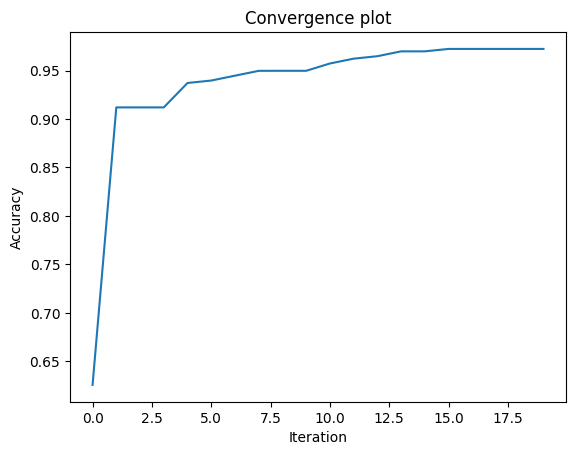

In [12]:
results['value'].sort_values().reset_index(drop=True).plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')